In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import DataLoader

In [2]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import pandas as pd
import seaborn as sn
import sklearn.metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms

from utils.eval_funcs import *
from utils.dataset_CIFAR100LT import *
from utils.network_arch_resnet import *
from utils.trainval import *
from utils.plot_funcs import *
import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
2.0.1


In [3]:
# 定义深度卷积神经网络模型
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            #nn.Linear(64 * 16 * 16, 128),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.classifier1 = nn.Sequential(
            #nn.Linear(64 * 16 * 16, 128),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.unknown_class = num_classes

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def open_set_forward(self, x, known_classes):
        x = self.features(x)
        #print(x.shape) 
        x = x.view(x.size(0), -1)
        #print(x.shape) 
        logits = self.classifier(x)

        # 计算每个样本的开放集得分
        open_scores = torch.softmax(logits[:, known_classes], dim=1)

        # 添加未知类别得分
        unknown_scores = torch.zeros(x.size(0), 1).to(x.device)
        open_scores = torch.cat((open_scores, unknown_scores), dim=1)

        return open_scores

In [4]:
# 设置随机种子和设备
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda


In [5]:
epoch_number=[]
loss_record=[]

In [6]:
class_number=[]
class_acc=[]
class_sample=[]

In [7]:
# 训练闭集模型
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_number.append(epoch)
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_record.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

In [8]:
# 测试开放集识别
def test(model, test_loader, known_classes):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            open_scores = model.open_set_forward(images, known_classes)
            _, predicted = torch.max(open_scores.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy}%")

In [9]:
# 数据预处理和加载器
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''

'\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((32, 32)),\n    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n])\n'

In [10]:

# Define the transformations for CIFAR10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [11]:
# Define the transformations for MNIST
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
'''
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_cifar)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
'''

"\ntrain_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_cifar)\ntrain_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)\n"

In [13]:
# 加载CIFAR10测试集
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform_cifar)
testloader = DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


In [14]:
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform_mnist)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [15]:
import numpy as np
from torchvision import datasets

def build_long_tailed_dataset(dataset, imbalance_ratio):
    num_classes = len(dataset.classes)
    class_counts = np.zeros(num_classes, dtype=int)
    
    for _, label in dataset:
        class_counts[label] += 1
    
    max_class_count = class_counts.max()
    
    # Calculate the number of samples to keep for each class based on the imbalance ratio
    #num_samples_per_class = np.zeros(num_classes, dtype=int)
    total_num=50000
    imb_type = 'exp' # samling long-tailed training set with an exponetially-decaying function
    imb_factor = 1 # imbalance factor = 100 = 1/0.01
    num_samples_per_class = get_img_num_per_cls(100, total_num, imb_type, imb_factor)
    #for i, count in enumerate(class_counts):
        #num_samples_per_class[i] = int(max_class_count / (imbalance_ratio ** i))
        #num_samples_per_class[i] = int(max_class_count -imbalance_ratio **i)
    
    # Create a new dataset with imbalanced class distribution
    long_tailed_dataset = []
    
    for data, label in dataset:
        class_count = class_counts[label]
        num_samples = num_samples_per_class[label]
        
        if class_count <= num_samples:
            long_tailed_dataset.extend([(data, label)] * class_count)
        else:
            long_tailed_dataset.extend([(data, label)] * num_samples)
    
    return long_tailed_dataset

# Load the CIFAR-100 dataset
cifar100_train = datasets.CIFAR100(root='data', train=True, download=True, transform=transform_cifar)

# Build a long-tailed version of the CIFAR-100 dataset with imbalance ratio of 10
imbalance_ratio = 1.06

long_tailed_cifar100_train = build_long_tailed_dataset(cifar100_train, imbalance_ratio)
#long_tailed_cifar100_train = cifar100_train

# Print the class distribution of the long-tailed dataset
class_counts = np.zeros(100, dtype=int)
for _, label in long_tailed_cifar100_train:
    class_counts[label] += 1

for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} samples")
    class_sample.append(count)

Files already downloaded and verified
Class 0: 250000 samples
Class 1: 250000 samples
Class 2: 250000 samples
Class 3: 250000 samples
Class 4: 250000 samples
Class 5: 250000 samples
Class 6: 250000 samples
Class 7: 250000 samples
Class 8: 250000 samples
Class 9: 250000 samples
Class 10: 250000 samples
Class 11: 250000 samples
Class 12: 250000 samples
Class 13: 250000 samples
Class 14: 250000 samples
Class 15: 250000 samples
Class 16: 250000 samples
Class 17: 250000 samples
Class 18: 250000 samples
Class 19: 250000 samples
Class 20: 250000 samples
Class 21: 250000 samples
Class 22: 250000 samples
Class 23: 250000 samples
Class 24: 250000 samples
Class 25: 250000 samples
Class 26: 250000 samples
Class 27: 250000 samples
Class 28: 250000 samples
Class 29: 250000 samples
Class 30: 250000 samples
Class 31: 250000 samples
Class 32: 250000 samples
Class 33: 250000 samples
Class 34: 250000 samples
Class 35: 250000 samples
Class 36: 250000 samples
Class 37: 250000 samples
Class 38: 250000 sampl

In [16]:
train_loader = DataLoader(long_tailed_cifar100_train, batch_size=64, shuffle=True, num_workers=2)

In [17]:
cifar100_test = datasets.CIFAR100(root='data', train=False, download=True, transform=transform_cifar)

Files already downloaded and verified


In [18]:
testloader=DataLoader(cifar100_test, batch_size=64, shuffle=True, num_workers=2)

In [19]:
# 初始化模型、损失函数和优化器
num_classes = 100  # 已知类别数量
#model = Model(num_classes)
model = models.resnet18(num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [21]:
# 训练模型
train(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 0.03713586194130064
Epoch [2/10], Loss: 0.0006994829061861417
Epoch [3/10], Loss: 0.0004999807700738451
Epoch [4/10], Loss: 0.0004485604977190846
Epoch [5/10], Loss: 0.00038443053487787366
Epoch [6/10], Loss: 0.0003472959105974796
Epoch [7/10], Loss: 0.00034773796158866593
Epoch [8/10], Loss: 0.000339702280444103
Epoch [9/10], Loss: 0.0003377338680710351
Epoch [10/10], Loss: 0.00032681185571833694


In [22]:
class_correct = [0] * 100
class_total = [0] * 100

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(100):
    class_number.append(i)
    accuracy = 100 * class_correct[i] / class_total[i]
    class_acc.append(accuracy)
    print(f'Accuracy of class {i}: {accuracy:.2f}%')

Accuracy of class 0: 81.00%
Accuracy of class 1: 73.00%
Accuracy of class 2: 41.00%
Accuracy of class 3: 24.00%
Accuracy of class 4: 36.00%
Accuracy of class 5: 60.00%
Accuracy of class 6: 59.00%
Accuracy of class 7: 58.00%
Accuracy of class 8: 69.00%
Accuracy of class 9: 68.00%
Accuracy of class 10: 38.00%
Accuracy of class 11: 31.00%
Accuracy of class 12: 65.00%
Accuracy of class 13: 35.00%
Accuracy of class 14: 52.00%
Accuracy of class 15: 48.00%
Accuracy of class 16: 59.00%
Accuracy of class 17: 70.00%
Accuracy of class 18: 52.00%
Accuracy of class 19: 48.00%
Accuracy of class 20: 79.00%
Accuracy of class 21: 73.00%
Accuracy of class 22: 50.00%
Accuracy of class 23: 82.00%
Accuracy of class 24: 74.00%
Accuracy of class 25: 44.00%
Accuracy of class 26: 50.00%
Accuracy of class 27: 38.00%
Accuracy of class 28: 71.00%
Accuracy of class 29: 51.00%
Accuracy of class 30: 56.00%
Accuracy of class 31: 54.00%
Accuracy of class 32: 42.00%
Accuracy of class 33: 51.00%
Accuracy of class 34: 56

In [23]:
# 测试模型
#test(model, test_loader, known_classes=list(range(num_classes)))

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, auc
'''
# 计算开放集似然性
def calculate_open_set_likelihood(testloader, open_set_loader):
    model.eval()
    softmax = nn.Softmax(dim=1)

    scores = []
    labels = []

    with torch.no_grad():
        for data in testloader:
            images, true_labels = data
            images = images.to(device)
            true_labels = true_labels.to(device)
            outputs = model(images)
            probabilities = softmax(outputs)
            max_probabilities, _ = torch.max(probabilities, 1)
            scores.extend(max_probabilities.cpu().numpy())
            labels.extend(true_labels.cpu().numpy())

    open_set_scores = []

    with torch.no_grad():
        for data in open_set_loader:
            images, _ = data
            images = images.to(device)
            outputs = model(images)
            probabilities = softmax(outputs)
            max_probabilities, _ = torch.max(probabilities, 1)
            open_set_scores.extend(max_probabilities.cpu().numpy())

    return np.array(scores), np.array(open_set_scores), np.array(labels)

# 计算似然性并绘制ROC曲线
scores, open_set_scores, labels = calculate_open_set_likelihood(testloader, test_loader)

fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
roc_auc = auc(fpr, tpr)

open_set_fpr, open_set_tpr, _ = roc_curve(np.concatenate((np.ones_like(labels), np.zeros_like(open_set_scores))), np.concatenate((scores, open_set_scores)))
open_set_roc_auc = auc(open_set_fpr, open_set_tpr)

# 绘制ROC曲线
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(open_set_fpr, open_set_tpr, color='blue', linestyle='--', label='Open-set ROC curve (area = %0.2f)' % open_set_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
'''

'\n# 计算开放集似然性\ndef calculate_open_set_likelihood(testloader, open_set_loader):\n    model.eval()\n    softmax = nn.Softmax(dim=1)\n\n    scores = []\n    labels = []\n\n    with torch.no_grad():\n        for data in testloader:\n            images, true_labels = data\n            images = images.to(device)\n            true_labels = true_labels.to(device)\n            outputs = model(images)\n            probabilities = softmax(outputs)\n            max_probabilities, _ = torch.max(probabilities, 1)\n            scores.extend(max_probabilities.cpu().numpy())\n            labels.extend(true_labels.cpu().numpy())\n\n    open_set_scores = []\n\n    with torch.no_grad():\n        for data in open_set_loader:\n            images, _ = data\n            images = images.to(device)\n            outputs = model(images)\n            probabilities = softmax(outputs)\n            max_probabilities, _ = torch.max(probabilities, 1)\n            open_set_scores.extend(max_probabilities.cpu().numpy())\

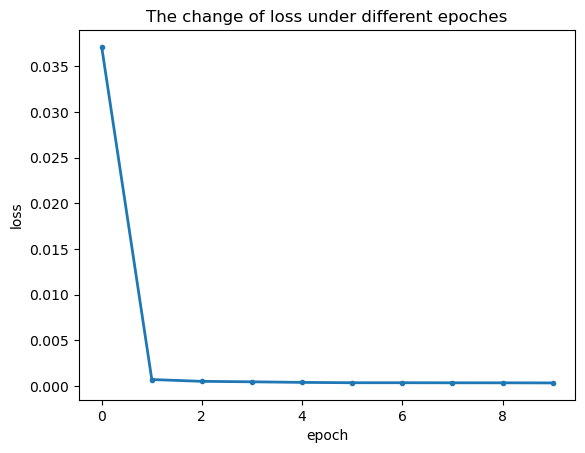

In [25]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("The change of loss under different epoches")
plt.plot(epoch_number, loss_record, linewidth=2,  marker='.')
#plt.legend()
plt.show()

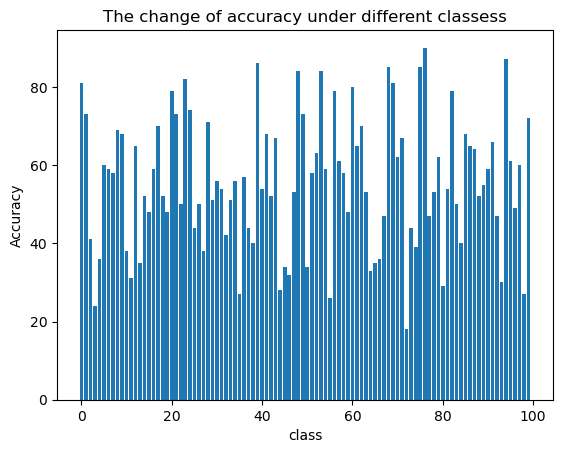

In [26]:
plt.xlabel('class')
plt.ylabel('Accuracy')
plt.title("The change of accuracy under different classess")
#plt.plot(class_number, class_acc, linewidth=2,  marker='.')
plt.bar(class_number, class_acc)
#plt.legend()
plt.show()